# April 6 : 12:23


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
from tqdm import tqdm
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np


In [10]:
# Discount factor for future utilities
DISCOUNT_FACTOR = 0.99
# Number of episodes to run
NUM_EPISODES = 500
# Max steps per episode
MAX_STEPS = 10000
# Device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [12]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [13]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()

    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [14]:
def process_rewards(rewards):
    ''' Converts our rewards history into cumulative discounted rewards
    Args:
    - rewards (Array): array of rewards

    Returns:
    - G (Array): array of cumulative discounted rewards
    '''
    #Calculate Gt (cumulative discounted rewards)
    G = []

    #track cumulative reward
    total_r = 0

    #iterate rewards from Gt to G0
    for r in reversed(rewards):

        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r * DISCOUNT_FACTOR

        #add to front of G
        G.insert(0, total_r)

    #whitening rewards
    G = torch.tensor(G).to(DEVICE)
    G = (G - G.mean())/G.std()

    return G

In [15]:
def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''

    #store updates
    policy_loss = []

    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)

    #Backpropagation
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()

In [17]:
def train_value(td_errors, optimizer):
    # Update state-value network parameters using TD(0)
    loss = torch.mean(td_errors ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()




In [18]:
def reinforce(env, use_baseline=False, num_episodes=NUM_EPISODES, discount_factor=DISCOUNT_FACTOR, max_steps=MAX_STEPS):
    # Init networks
    policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
    stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

    # Init optimizers
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-2)
    stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=1e-2)

    # Track scores
    scores = []
    recent_scores = deque(maxlen=100)

    # Iterate through episodes
    for episode in tqdm(range(num_episodes)):
        # Reset environment, initialize variables
        state = env.reset()
        trajectory = []
        score = 0

        # Generate episode
        for step in range(max_steps):
            # Select action
            action, lp = select_action(policy_network, state)

            # Execute action
            new_state, reward, done, _ = env.step(action)

            # Track episode score
            score += reward

            # Store into trajectory
            trajectory.append([state, action, reward, lp])

            # End episode if done
            if done:
                break

            # Move into new state
            state = new_state

        # Append score
        scores.append(score)
        recent_scores.append(score)

        # Get items from trajectory
        states = [step[0] for step in trajectory]
        actions = [step[1] for step in trajectory]
        rewards = [step[2] for step in trajectory]
        lps = [step[3] for step in trajectory]

        # Get discounted rewards
        G = process_rewards(rewards)

        # Calculate state values and train state-value network
        state_vals = []
        for state in states:
            state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
            state_vals.append(stateval_network(state))
        state_vals = torch.stack(state_vals).squeeze()

        if use_baseline:
            # Calculate TD errors and update state-value network
            td_errors = []
            for i in range(len(G)):
                td_error = G[i] - state_vals[i]
                td_errors.append(td_error)
            td_errors = torch.stack(td_errors)
            train_value(td_errors, stateval_optimizer)

            # Calculate deltas and train policy network
            deltas = [gt - val for gt, val in zip(G, state_vals)]
            deltas = torch.tensor(deltas).to(DEVICE)
        else:
            deltas = G

        train_policy(deltas, lps, policy_optimizer)

    return scores

In [21]:
# Run experiments
env_names = ['Acrobot-v1']
num_seeds = 1
results = {}

for env_name in env_names:
    env = gym.make(env_name)
    results[env_name] = {}

    for use_baseline in [False, True]:
        all_scores = []
        for seed in range(num_seeds):
            torch.manual_seed(seed)
            np.random.seed(seed)
            env.seed(seed)

            scores = reinforce(env, use_baseline=use_baseline)
            all_scores.append(scores)

        # Calculate mean and variance of scores across seeds
        all_scores = np.array(all_scores)
        mean_scores = np.mean(all_scores, axis=0)
        std_scores = np.std(all_scores, axis=0)

        # Store results
        results[env_name][use_baseline] = {'mean': mean_scores, 'std': std_scores}

    env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 1000/1000 [12:58<00:00,  1.28it/s]


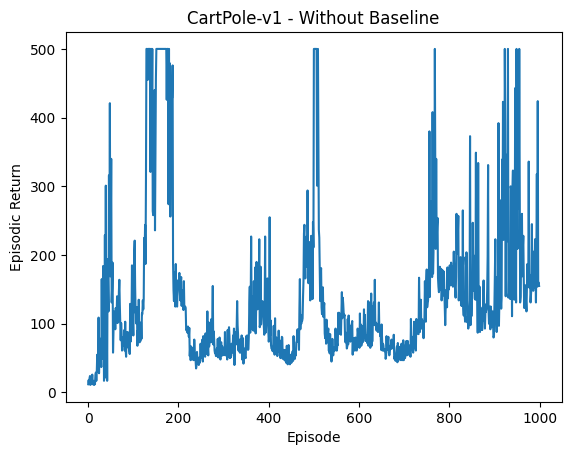

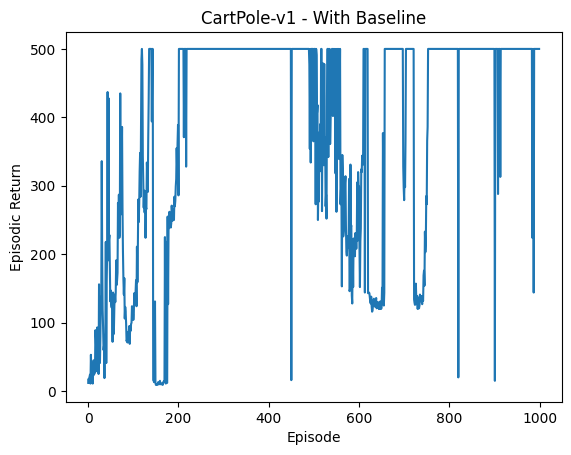

In [20]:
# Plot results
for env_name in env_names:
    for use_baseline in [False, True]:
        mean_scores = results[env_name][use_baseline]['mean']
        std_scores = results[env_name][use_baseline]['std']

        # Plot episodic return vs. episode number
        plt.figure()
        plt.plot(mean_scores)
        plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.3)
        plt.xlabel('Episode')
        plt.ylabel('Episodic Return')
        plt.title(f'{env_name} - {"With" if use_baseline else "Without"} Baseline')
        plt.show()

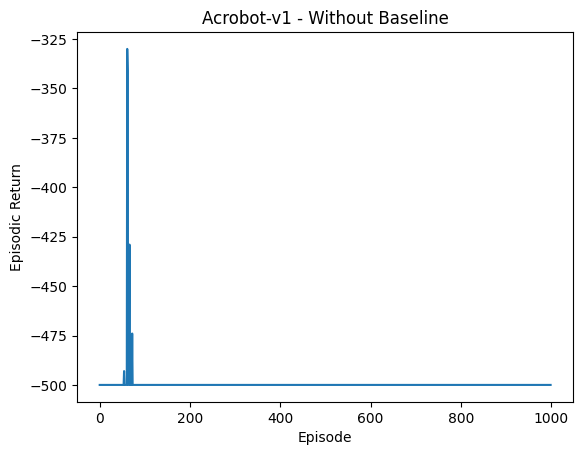

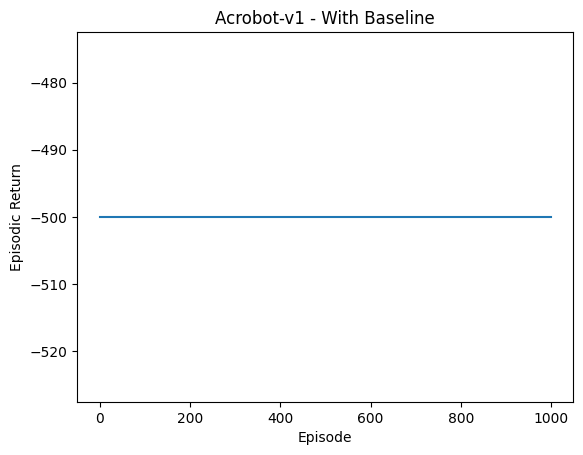

In [22]:
# Plot results
for env_name in env_names:
    for use_baseline in [False, True]:
        mean_scores = results[env_name][use_baseline]['mean']
        std_scores = results[env_name][use_baseline]['std']

        # Plot episodic return vs. episode number
        plt.figure()
        plt.plot(mean_scores)
        plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.3)
        plt.xlabel('Episode')
        plt.ylabel('Episodic Return')
        plt.title(f'{env_name} - {"With" if use_baseline else "Without"} Baseline')
        plt.show()